In [111]:
import numpy as np
import os
import glob
from python_speech_features import mfcc, logfbank, get_filterbanks
from python_speech_features.sigproc import preemphasis, framesig, powspec
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Masking, TimeDistributed, Conv1D, Flatten, Reshape
from keras.optimizers import SGD
from keras import metrics
import scipy.io.wavfile as wav
import sys
import subprocess
import h5py

In [2]:
TEST_NAMES = ['aa', 'ae', 'ah', 'aw', 'ay', 'b', 'ch', 'd', 'dh', 'dx', 'eh', 'er', 'ey',
              'f', 'g', 'hh', 'ih', 'iy', 'jh', 'k', 'l', 'm', 'n', 'ng', 'ow', 'oy', 'p',
              'r', 's', 'sh', 'sil', 't', 'th', 'uh', 'uw', 'v', 'w', 'y', 'z']

FOLDINGS = {
    "ux": "uw",
    "axr": "er",
    "axh": "ah",
    "ax-h": "ah",
    "ax": "ah",
    "em": "m",
    "nx": "n",
    "en": "n",
    "eng": "ng",
    "hv": "hh",
    "el": "l",
    "zh": "sh",
    "ao": "aa",
    "ix": "ih",
    "pcl": "sil",
    "tcl": "sil",
    "kcl": "sil",
    "qcl": "sil",
    "bcl": "sil",
    "dcl": "sil",
    "gcl": "sil",
    "h#": "sil",
    "#h": "sil",
    "pau": "sil",
    "epi": "sil"
}

In [3]:
def phn_file_to_labels(fname, winstep=0.01, rate=16000.0):
    # Load PHN file
    phn_text = np.loadtxt(fname,
                          dtype={'names': ('start', 'end', 'phone'),
                                 'formats': (np.int32, np.int32, 'S4')},
                          comments=None)

    # Length of annotations in num samples
    _, phn_len, _ = phn_text[-1]
    labels = []
    for i, (start, end, phn) in enumerate(phn_text):
        # Round the start & end times to the window start
        start = int(start / (rate * winstep))
        end = int(end / (rate * winstep))
        labels.extend([phn.decode("utf-8")] * (end - start))

    return np.asarray(labels)


def fold_label(phn):
    if phn in FOLDINGS:
        return FOLDINGS[phn]
    else:
        return phn


def label_to_int(phn):
    return TEST_NAMES.index(phn)


def to_one_hot(labels, num_classes=48):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels.ravel()] = 1
    return labels_one_hot

In [4]:
source_dir = '/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN'
target_dir = '/home/tvniedek/TIMIT/TRAIN'

drs = sorted(glob.glob(os.path.join(source_dir, 'DR*')))
cmd = "sox {0} -t wav {1}"

#target_file_X = h5py.File(os.path.join(target_dir, 'features_framed.h5'), "w")
#target_file_Y = h5py.File(os.path.join(target_dir, 'features_preemph.h5'), "w")

winlen = 0.025
winstep = 0.01

X = []
Y = []

for dialect_region_dir in drs:
    print(dialect_region_dir)
    dr = os.path.split(dialect_region_dir)[-1]
    for speaker_dir in sorted(glob.glob(os.path.join(dialect_region_dir, "*"))):
        speaker = os.path.split(speaker_dir)[-1]
        print(speaker_dir)
        for audio_file in sorted(glob.glob(os.path.join(speaker_dir, "*.WAV"))):
            fname = os.path.splitext(os.path.split(audio_file)[-1])[0]
            if fname[8:10] == "SA":
                continue
            print(audio_file)
            file_target_dir = os.path.join(target_dir, dr, speaker)
            if not os.path.exists(file_target_dir):
                os.makedirs(file_target_dir)

            # Convert NIST wav files using sox
            converted_target_file = os.path.join(file_target_dir, os.path.split(audio_file)[-1])
            if not os.path.isfile(converted_target_file):
                subprocess.call(cmd.format(audio_file, converted_target_file), shell=True)

            (rate, sig) = wav.read(converted_target_file)
            #print(sig.shape)
            
            # Convert to overlapping frames
            x = framesig(sig, winlen * rate, winstep * rate)
            
            # Pre-emphasis
            sig_preemph = preemphasis(sig)
            
            # Convert to overlapping frames
            y = framesig(sig_preemph, winlen * rate, winstep * rate)
            
            
            
            for frame in x:
                X.append(frame)
            for frame in y:
                Y.append(frame)
            
            #group = target_file_X.create_group(fname)
            #group.create_dataset('features', data=x)
            #group2 = target_file_Y.create_group(fname)
            #group2.create_dataset('features', data=y)

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FCJF0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SI1027.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SI1657.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SI648.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SX127.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SX217.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SX307.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SX37.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FCJF0/DR1FCJF0SX397.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FDAW0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FDAW0/DR1FDAW0SI1271.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FDAW0/DR1FDAW0SI

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FVMH0/DR1FVMH0SX206.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FVMH0/DR1FVMH0SX26.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FVMH0/DR1FVMH0SX296.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/FVMH0/DR1FVMH0SX386.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MCPM0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MCPM0/DR1MCPM0SI1194.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MCPM0/DR1MCPM0SI1824.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MCPM0/DR1MCPM0SI564.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MCPM0/DR1MCPM0SX114.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MCPM0/DR1MCPM0SX204.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MCPM0/DR1MCPM0SX24.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MCPM0/DR1MCPM0SX294.WAV
/vol/bigdata2/smurfland_archive/da

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPGR0/DR1MPGR0SX420.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPGR0/DR1MPGR0SX60.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPSW0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPSW0/DR1MPSW0SI1067.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPSW0/DR1MPSW0SI1697.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPSW0/DR1MPSW0SI2327.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPSW0/DR1MPSW0SX167.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPSW0/DR1MPSW0SX24.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPSW0/DR1MPSW0SX257.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPSW0/DR1MPSW0SX437.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MPSW0/DR1MPSW0SX77.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR1/MRAI0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAI

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAEM0/DR2FAEM0SX402.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAEM0/DR2FAEM0SX42.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAJW0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAJW0/DR2FAJW0SI1263.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAJW0/DR2FAJW0SI1893.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAJW0/DR2FAJW0SI633.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAJW0/DR2FAJW0SX183.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAJW0/DR2FAJW0SX273.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAJW0/DR2FAJW0SX3.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAJW0/DR2FAJW0SX363.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FAJW0/DR2FAJW0SX93.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FCAJ0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMA0/DR2FLMA0SX253.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMA0/DR2FLMA0SX343.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMA0/DR2FLMA0SX433.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMA0/DR2FLMA0SX73.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMC0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMC0/DR2FLMC0SI1372.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMC0/DR2FLMC0SI2002.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMC0/DR2FLMC0SI742.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMC0/DR2FLMC0SX112.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMC0/DR2FLMC0SX22.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMC0/DR2FLMC0SX292.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/FLMC0/DR2FLMC0SX336.WAV
/vol/bigdata2/smurfland_archive/da

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCEW0/DR2MCEW0SX452.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCEW0/DR2MCEW0SX92.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCTM0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SI1350.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SI1980.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SI720.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SX180.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SX270.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SX360.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SX450.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MCTM0/DR2MCTM0SX90.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MDBP0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAI

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJDE0/DR2MJDE0SX400.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJEB0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJEB0/DR2MJEB0SI1286.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJEB0/DR2MJEB0SI1916.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJEB0/DR2MJEB0SI656.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJEB0/DR2MJEB0SX170.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJEB0/DR2MJEB0SX206.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJEB0/DR2MJEB0SX26.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJEB0/DR2MJEB0SX296.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJEB0/DR2MJEB0SX386.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJHI0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MJHI0/DR2MJHI0SI1328.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TR

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMGK0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMGK0/DR2MMGK0SI1322.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMGK0/DR2MMGK0SI1952.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMGK0/DR2MMGK0SI692.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMGK0/DR2MMGK0SX152.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMGK0/DR2MMGK0SX242.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMGK0/DR2MMGK0SX332.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMGK0/DR2MMGK0SX422.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMGK0/DR2MMGK0SX62.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMXS0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMXS0/DR2MMXS0SI2136.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MMXS0/DR2MMXS0SI629.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TR

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLJ0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLJ0/DR2MRLJ0SI1420.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLJ0/DR2MRLJ0SI2050.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLJ0/DR2MRLJ0SI790.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLJ0/DR2MRLJ0SX160.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLJ0/DR2MRLJ0SX250.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLJ0/DR2MRLJ0SX340.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLJ0/DR2MRLJ0SX430.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLJ0/DR2MRLJ0SX70.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLR0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLR0/DR2MRLR0SI1196.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR2/MRLR0/DR2MRLR0SI1826.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/T

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FCMG0/DR3FCMG0SX72.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDFB0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDFB0/DR3FDFB0SI1318.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDFB0/DR3FDFB0SI1948.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDFB0/DR3FDFB0SI2010.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDFB0/DR3FDFB0SX148.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDFB0/DR3FDFB0SX238.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDFB0/DR3FDFB0SX328.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDFB0/DR3FDFB0SX418.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDFB0/DR3FDFB0SX58.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDJH0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FDJH0/DR3FDJH0SI1565.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TR

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FNTB0/DR3FNTB0SX393.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FPAZ0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FPAZ0/DR3FPAZ0SI1593.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FPAZ0/DR3FPAZ0SI2223.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FPAZ0/DR3FPAZ0SI963.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FPAZ0/DR3FPAZ0SX153.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FPAZ0/DR3FPAZ0SX243.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FPAZ0/DR3FPAZ0SX27.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FPAZ0/DR3FPAZ0SX423.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FPAZ0/DR3FPAZ0SX63.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FSJS0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/FSJS0/DR3FSJS0SI1171.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRA

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDC0/DR3MCDC0SX302.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDC0/DR3MCDC0SX32.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDC0/DR3MCDC0SX392.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDD0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDD0/DR3MCDD0SI1513.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDD0/DR3MCDD0SI2143.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDD0/DR3MCDD0SI883.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDD0/DR3MCDD0SX163.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDD0/DR3MCDD0SX253.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDD0/DR3MCDD0SX343.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDD0/DR3MCDD0SX433.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MCDD0/DR3MCDD0SX73.WAV
/vol/bigdata2/smurfland_archive/da

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MFMC0/DR3MFMC0SX52.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MGAF0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MGAF0/DR3MGAF0SI1282.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MGAF0/DR3MGAF0SI1912.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MGAF0/DR3MGAF0SI652.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MGAF0/DR3MGAF0SX112.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MGAF0/DR3MGAF0SX202.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MGAF0/DR3MGAF0SX22.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MGAF0/DR3MGAF0SX292.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MGAF0/DR3MGAF0SX382.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MHJB0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MHJB0/DR3MHJB0SI1017.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRA

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAM0/DR3MMAM0SI2227.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAM0/DR3MMAM0SX157.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAM0/DR3MMAM0SX247.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAM0/DR3MMAM0SX337.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAM0/DR3MMAM0SX427.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAM0/DR3MMAM0SX67.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAR0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAR0/DR3MMAR0SI1336.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAR0/DR3MMAR0SI1966.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAR0/DR3MMAR0SI706.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAR0/DR3MMAR0SX166.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MMAR0/DR3MMAR0SX256.WAV
/vol/bigdata2/smurfland_archive/

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRTJ0/DR3MRTJ0SI2032.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRTJ0/DR3MRTJ0SI772.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRTJ0/DR3MRTJ0SX142.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRTJ0/DR3MRTJ0SX232.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRTJ0/DR3MRTJ0SX322.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRTJ0/DR3MRTJ0SX412.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRTJ0/DR3MRTJ0SX52.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRWA0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRWA0/DR3MRWA0SI1603.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRWA0/DR3MRWA0SI2233.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRWA0/DR3MRWA0SI973.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR3/MRWA0/DR3MRWA0SX163.WAV
/vol/bigdata2/smurfland_archive/

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FCAG0/DR4FCAG0SI1641.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FCAG0/DR4FCAG0SI2133.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FCAG0/DR4FCAG0SX153.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FCAG0/DR4FCAG0SX243.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FCAG0/DR4FCAG0SX333.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FCAG0/DR4FCAG0SX423.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FCAG0/DR4FCAG0SX63.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FDKN0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FDKN0/DR4FDKN0SI1081.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FDKN0/DR4FDKN0SI1202.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FDKN0/DR4FDKN0SI1711.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/FDKN0/DR4FDKN0SX181.WAV
/vol/bigdata2/smurfland_archiv

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MARW0/DR4MARW0SX376.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBMA0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBMA0/DR4MBMA0SI1222.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBMA0/DR4MBMA0SI1852.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBMA0/DR4MBMA0SI592.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBMA0/DR4MBMA0SX142.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBMA0/DR4MBMA0SX232.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBMA0/DR4MBMA0SX322.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBMA0/DR4MBMA0SX412.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBMA0/DR4MBMA0SX52.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBWP0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MBWP0/DR4MBWP0SI1531.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TR

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGRP0/DR4MGRP0SI687.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGRP0/DR4MGRP0SX147.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGRP0/DR4MGRP0SX237.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGRP0/DR4MGRP0SX327.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGRP0/DR4MGRP0SX417.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGRP0/DR4MGRP0SX57.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGXP0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGXP0/DR4MGXP0SI1087.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGXP0/DR4MGXP0SI457.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGXP0/DR4MGXP0SI525.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGXP0/DR4MGXP0SX187.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MGXP0/DR4MGXP0SX277.WAV
/vol/bigdata2/smurfland_archive/da

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MJXL0/DR4MJXL0SX182.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MJXL0/DR4MJXL0SX272.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MJXL0/DR4MJXL0SX362.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MJXL0/DR4MJXL0SX452.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MJXL0/DR4MJXL0SX92.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MKAM0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MKAM0/DR4MKAM0SI1250.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MKAM0/DR4MKAM0SI1316.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MKAM0/DR4MKAM0SI1465.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MKAM0/DR4MKAM0SX146.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MKAM0/DR4MKAM0SX236.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MKAM0/DR4MKAM0SX326.WAV
/vol/bigdata2/smurfland_archive/

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRK0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRK0/DR4MPRK0SI1097.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRK0/DR4MPRK0SI1727.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRK0/DR4MPRK0SI467.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRK0/DR4MPRK0SX107.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRK0/DR4MPRK0SX17.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRK0/DR4MPRK0SX197.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRK0/DR4MPRK0SX287.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRK0/DR4MPRK0SX377.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRT0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRT0/DR4MPRT0SI1210.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MPRT0/DR4MPRT0SI495.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TR

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SI1857.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SI597.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SX147.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SX237.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SX254.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SX417.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR4/MTRT0/DR4MTRT0SX57.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FBJL0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SI1552.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SI2182.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FBJL0/DR5FBJL0SI922.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLJG0/DR5FLJG0SX171.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLJG0/DR5FLJG0SX261.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLJG0/DR5FLJG0SX351.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLJG0/DR5FLJG0SX441.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLJG0/DR5FLJG0SX81.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLMK0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLMK0/DR5FLMK0SI1035.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLMK0/DR5FLMK0SI1229.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLMK0/DR5FLMK0SI2295.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLMK0/DR5FLMK0SX135.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLMK0/DR5FLMK0SX225.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/FLMK0/DR5FLMK0SX315.WAV
/vol/bigdata2/smurfland_archive/

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MCLM0/DR5MCLM0SI2086.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MCLM0/DR5MCLM0SI826.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MCLM0/DR5MCLM0SX106.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MCLM0/DR5MCLM0SX16.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MCLM0/DR5MCLM0SX196.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MCLM0/DR5MCLM0SX286.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MCLM0/DR5MCLM0SX376.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MDAS0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MDAS0/DR5MDAS0SI1266.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MDAS0/DR5MDAS0SI1896.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MDAS0/DR5MDAS0SI636.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MDAS0/DR5MDAS0SX186.WAV
/vol/bigdata2/smurfland_archive/

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJFH0/DR5MJFH0SX117.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJFH0/DR5MJFH0SX207.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJFH0/DR5MJFH0SX27.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJFH0/DR5MJFH0SX297.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJFH0/DR5MJFH0SX387.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJPG0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SI1191.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SI1821.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SI561.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SX111.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SX201.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MJPG0/DR5MJPG0SX21.WAV
/vol/bigdata2/smurfland_archive/da

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRKM0/DR5MRKM0SX7.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRKM0/DR5MRKM0SX97.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRLD0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRLD0/DR5MRLD0SI1594.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRLD0/DR5MRLD0SI2224.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRLD0/DR5MRLD0SI964.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRLD0/DR5MRLD0SX154.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRLD0/DR5MRLD0SX244.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRLD0/DR5MRLD0SX334.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRLD0/DR5MRLD0SX424.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRLD0/DR5MRLD0SX64.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MRML0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWAC0/DR5MWAC0SX161.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWAC0/DR5MWAC0SX251.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWAC0/DR5MWAC0SX341.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWAC0/DR5MWAC0SX431.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWAC0/DR5MWAC0SX71.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWCH0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWCH0/DR5MWCH0SI1622.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWCH0/DR5MWCH0SI1895.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWCH0/DR5MWCH0SI2252.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWCH0/DR5MWCH0SX182.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWCH0/DR5MWCH0SX272.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR5/MWCH0/DR5MWCH0SX362.WAV
/vol/bigdata2/smurfland_archive/

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSBK0/DR6FSBK0SI1699.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSBK0/DR6FSBK0SI2329.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSBK0/DR6FSBK0SX169.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSBK0/DR6FSBK0SX259.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSBK0/DR6FSBK0SX349.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSBK0/DR6FSBK0SX439.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSBK0/DR6FSBK0SX79.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSDJ0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSDJ0/DR6FSDJ0SI1115.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSDJ0/DR6FSDJ0SI1745.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSDJ0/DR6FSDJ0SI485.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/FSDJ0/DR6FSDJ0SX125.WAV
/vol/bigdata2/smurfland_archive

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MKLN0/DR6MKLN0SX428.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MKLN0/DR6MKLN0SX68.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MMDB0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MMDB0/DR6MMDB0SI1358.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MMDB0/DR6MMDB0SI1617.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MMDB0/DR6MMDB0SI987.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MMDB0/DR6MMDB0SX177.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MMDB0/DR6MMDB0SX267.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MMDB0/DR6MMDB0SX357.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MMDB0/DR6MMDB0SX447.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MMDB0/DR6MMDB0SX87.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR6/MPGR1
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAI

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCJS0/DR7FCJS0SX257.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCJS0/DR7FCJS0SX347.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCJS0/DR7FCJS0SX437.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCJS0/DR7FCJS0SX77.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCRZ0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCRZ0/DR7FCRZ0SI1913.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCRZ0/DR7FCRZ0SI2053.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCRZ0/DR7FCRZ0SI793.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCRZ0/DR7FCRZ0SX163.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCRZ0/DR7FCRZ0SX253.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCRZ0/DR7FCRZ0SX343.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FCRZ0/DR7FCRZ0SX433.WAV
/vol/bigdata2/smurfland_archive/d

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FREH0/DR7FREH0SX325.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FREH0/DR7FREH0SX415.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FREH0/DR7FREH0SX55.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FSPM0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FSPM0/DR7FSPM0SI1241.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FSPM0/DR7FSPM0SI1871.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FSPM0/DR7FSPM0SI611.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FSPM0/DR7FSPM0SX161.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FSPM0/DR7FSPM0SX251.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FSPM0/DR7FSPM0SX341.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FSPM0/DR7FSPM0SX431.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/FSPM0/DR7FSPM0SX71.WAV
/vol/bigdata2/smurfland_archive/da

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDED0/DR7MDED0SX180.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDED0/DR7MDED0SX270.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDED0/DR7MDED0SX360.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDED0/DR7MDED0SX450.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDED0/DR7MDED0SX90.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDKS0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDKS0/DR7MDKS0SI1066.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDKS0/DR7MDKS0SI1696.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDKS0/DR7MDKS0SI2326.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDKS0/DR7MDKS0SX166.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDKS0/DR7MDKS0SX256.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MDKS0/DR7MDKS0SX346.WAV
/vol/bigdata2/smurfland_archive/

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHBS0/DR7MHBS0SX315.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHBS0/DR7MHBS0SX405.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHBS0/DR7MHBS0SX45.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHXL0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHXL0/DR7MHXL0SI1772.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHXL0/DR7MHXL0SI512.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHXL0/DR7MHXL0SI612.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHXL0/DR7MHXL0SX152.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHXL0/DR7MHXL0SX242.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHXL0/DR7MHXL0SX332.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHXL0/DR7MHXL0SX422.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MHXL0/DR7MHXL0SX62.WAV
/vol/bigdata2/smurfland_archive/dat

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MPAR0/DR7MPAR0SX46.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MPFU0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MPFU0/DR7MPFU0SI1258.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MPFU0/DR7MPFU0SI1888.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MPFU0/DR7MPFU0SI628.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MPFU0/DR7MPFU0SX178.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MPFU0/DR7MPFU0SX268.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MPFU0/DR7MPFU0SX358.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MPFU0/DR7MPFU0SX448.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MPFU0/DR7MPFU0SX88.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MREM0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MREM0/DR7MREM0SI1591.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRA

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTLC0/DR7MTLC0SI847.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTLC0/DR7MTLC0SX127.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTLC0/DR7MTLC0SX217.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTLC0/DR7MTLC0SX307.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTLC0/DR7MTLC0SX37.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTLC0/DR7MTLC0SX397.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTML0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTML0/DR7MTML0SI1065.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTML0/DR7MTML0SI1695.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTML0/DR7MTML0SI2325.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTML0/DR7MTML0SX165.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR7/MTML0/DR7MTML0SX255.WAV
/vol/bigdata2/smurfland_archive/

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FNKL0/DR8FNKL0SI892.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FNKL0/DR8FNKL0SX172.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FNKL0/DR8FNKL0SX196.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FNKL0/DR8FNKL0SX262.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FNKL0/DR8FNKL0SX442.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FNKL0/DR8FNKL0SX82.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FPLS0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FPLS0/DR8FPLS0SI1590.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FPLS0/DR8FPLS0SI2220.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FPLS0/DR8FPLS0SI960.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FPLS0/DR8FPLS0SX150.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/FPLS0/DR8FPLS0SX240.WAV
/vol/bigdata2/smurfland_archive/d

/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MMWS0/DR8MMWS0SX438.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MMWS0/DR8MMWS0SX78.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MRDM0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SI1044.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SI1595.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SI965.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SX155.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SX245.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SX335.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SX425.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MRDM0/DR8MRDM0SX65.WAV
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAIN/DR8/MRLK0
/vol/bigdata2/smurfland_archive/databases/TIMIT/TRAI

In [13]:
np.asarray(X).shape

(1128519, 400)

In [33]:
def safe_log(features):
    features = np.where(features == 0, np.finfo(float).eps, features)
    return np.log(features)

def normalize(sequence):
    return (sequence - np.mean(sequence, axis=0)) / np.std(sequence, axis=0)

def median_normalize(sequence):
    return (sequence - np.median(sequence, axis=0))

def normalize_scale(sequence):
    return (sequence - np.min(sequence, axis=0)) / (np.max(sequence, axis=0) - np.min(sequence, axis=0))

class TimitTargetGenerator(object):
    def __init__(self, datafile_source, datafile_target, keys=None, batch_size=20, shuffle=True, mask_value=0.):
        self._datafile = datafile_source
        self._datafile_target = datafile_target
        self._batch_size = batch_size
        if keys is None:
            self._keys = list(datafile_source.keys())
        else:
            self._keys = keys
        self._batch_index = 0
        self._shuffle = shuffle
        self._mask_value = mask_value

    def shuffle_keys(self):
        random.shuffle(self._keys)

    def next_sample(self):
        key = self._keys[self._batch_index]
        self._batch_index += 1
        if self._batch_index == len(self._keys):
            self._batch_index = 0
            if self._shuffle:
                self.shuffle_keys()
        return key
    
    def pad_features(self, sequence, target_length):
        return np.pad(sequence,
                      ((0, target_length - sequence.shape[0]), (0, 0)), 'constant',
                      constant_values=((0, self._mask_value), (0, 0)))

    def pad_labels(self, sequence, target_length):
        return np.pad(sequence,
                      ((0, target_length - sequence.shape[0]), (0, 0)), 'constant',
                      constant_values=((0, 0), (0, 0)))
    
    def generator(self):
        while True:
            batch_keys = [self.next_sample() for _ in range(self._batch_size)]
            batch_features = [self._datafile[key]['features'][()] for key in batch_keys]
            batch_targets = [self._datafile_target[key]['features'][()] for key in batch_keys]
            
            yield batch_features, batch_targets

In [34]:
train_data_source_file = '../../TIMIT/0_frames/TRAIN/features_framed.h5'
train_data_target_file = '../../TIMIT/0_frames/TRAIN/features_preemph.h5'

train_data_source = h5py.File(train_data_source_file, 'r')
train_data_target = h5py.File(train_data_target_file, 'r')
train_generator = TimitTargetGenerator(train_data_source, train_data_target)

In [32]:
list(train_data_source['DR1FCJF0SA1']['features'])

[array([ 1., -1.,  2.,  0.,  0.,  3.,  0.,  1., -3., -2.,  2.,  1.,  0.,
         0.,  3.,  5.,  5.,  5.,  5.,  5.,  4.,  3.,  5.,  5.,  5.,  5.,
         4.,  1.,  5.,  0.,  2.,  6.,  4.,  5.,  4.,  6.,  4.,  2.,  2.,
        -3., -1., -2.,  4.,  5.,  1., -1., -2., -4., -1.,  4.,  3.,  6.,
         4.,  6.,  3.,  4.,  0.,  5.,  5.,  3., -3., -1.,  0., -3.,  1.,
         0., -3., -2.,  4., -2.,  0.,  4.,  2.,  3., -2., -3., -2.,  1.,
         4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  1.,  1.,
        -2., -3., -2., -2., -2.,  1.,  3.,  5.,  5.,  5.,  5.,  5.,  5.,
         3.,  4.,  1.,  1.,  0.,  2.,  5.,  5.,  5.,  5.,  4.,  1.,  5.,
         4.,  3.,  6.,  1.,  5.,  5.,  5.,  2.,  5.,  5.,  5.,  6.,  5.,
         5.,  6.,  4.,  2.,  5.,  5.,  4.,  2.,  4.,  3.,  2.,  4.,  5.,
         5.,  5.,  2.,  6.,  3.,  6.,  2.,  1.,  3.,  2., -1.,  2.,  1.,
         2.,  3., -2., -3., -2., -2., -3.,  3.,  3.,  3.,  2.,  6.,  4.,
         5.,  5.,  5.,  5.,  5.,  5.,  3.,  3.,  4.

In [36]:
x_train, y_train = next(train_generator.generator())

In [8]:
np.asarray(X).shape

(2397, 400)

In [18]:
Y[100]

array([  26.9 , -109.8 ,  -23.4 ,  188.6 ,  120.25, -221.  , -132.6 ,
        178.8 ,   64.1 ,  -74.8 ,  -55.8 ,   63.35,  -17.4 ,   24.65,
       -179.15,  155.8 ,   36.95,  -88.25,  -16.8 ,  100.45,  -11.4 ,
       -189.1 ,  154.35,   96.45,  -19.75, -210.  ,   41.3 ,  180.7 ,
          2.95, -241.15,   55.55,  159.7 ,  -63.1 ,  -83.45,  187.35,
         -9.1 , -290.85,  101.35,   56.9 ,  118.95,  -70.05, -107.8 ,
         35.75,  103.75,  -93.95,  -34.8 ,  211.55, -139.7 ,   35.95,
         19.75,  -45.35,  160.25, -171.75,  -24.75,  145.05,  -34.6 ,
        -84.6 , -184.  ,  168.85,  146.8 , -170.8 ,   16.35,  -16.7 ,
         88.55,  -23.9 , -125.2 ,  172.5 ,  -37.6 ,  -29.65,  -16.2 ,
        -64.  ,  112.85, -122.3 ,  -48.5 ,  209.3 ,  -28.9 ,   -3.55,
       -179.85,  225.05,  147.65, -458.2 ,  117.3 ,  235.75,   56.8 ,
       -128.7 , -135.6 ,   29.5 ,  -16.8 ,   -9.5 ,  161.2 ,   41.45,
       -135.7 , -161.8 ,  269.15,    4.05, -124.  ,  -53.45,  158.95,
       -125.9 ,   41

In [71]:
def model():
    model = Sequential()
    model.add(Conv1D(128, 5, activation='relu', padding='same', input_shape=(400, 1)))
    model.add(Conv1D(1, 1, padding='same'))
    model.summary()
    sgd = SGD(lr=0.05)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=[metrics.mae, metrics.mse])
    return model

In [72]:
model_normal = model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 400, 128)          768       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 400, 1)            129       
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [6]:
X = np.asarray(X)
Y = np.asarray(Y)
X = np.expand_dims(X, axis=2)
Y = np.expand_dims(Y, axis=2)

In [51]:
X_norm = (X - X.mean()) / X.std()

In [7]:
Y_norm = (Y - Y.mean()) / Y.std()

In [73]:
model_normal.fit(X_norm, Y_norm)

Epoch 1/10
1128519/1128519 [==============================] - 1392s - loss: 0.0129 - mean_absolute_error: 0.0121 - mean_squared_error: 0.0129  
Epoch 2/10
 132032/1128519 [==>...........................] - ETA: 1191s - loss: 0.0100 - mean_absolute_error: 0.0095 - mean_squared_error: 0.0100

KeyboardInterrupt: 

In [74]:
y_pred = model_normal.predict(X_norm[1000000:1001000])

In [8]:
import matplotlib.pyplot as plt

In [62]:
y_pred.shape

(1000, 400, 1)

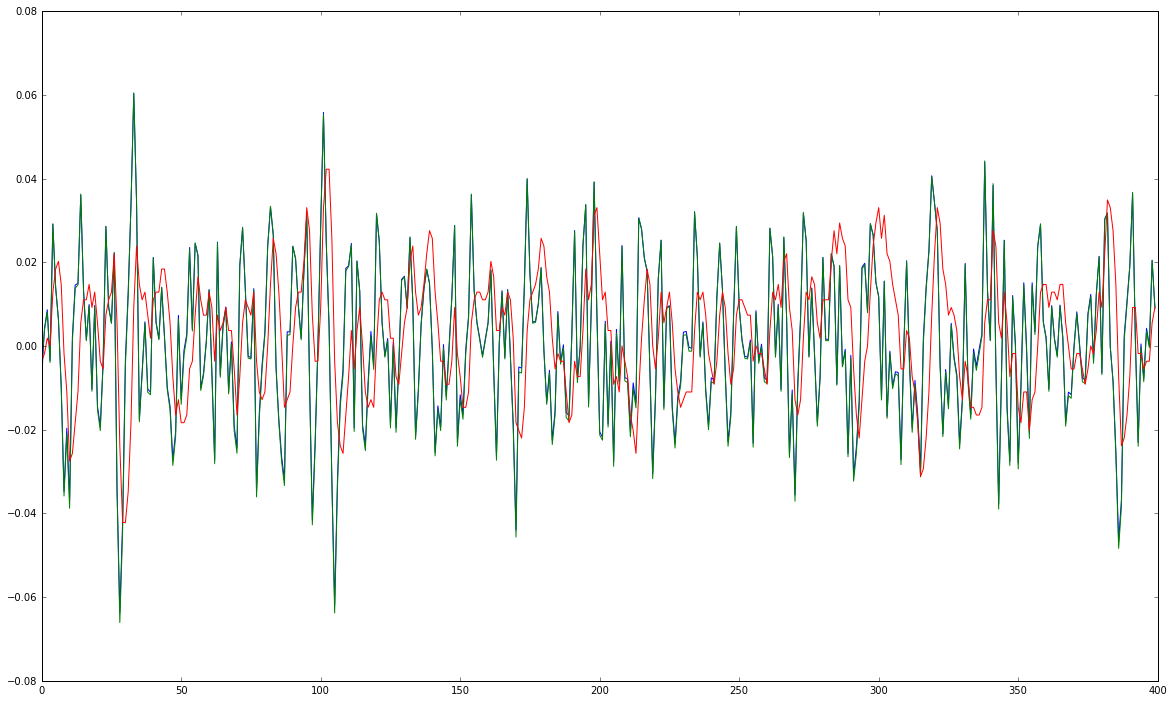

In [76]:
plt.figure(figsize=(20,12))

plt.plot(np.arange(400), y_pred[0].squeeze())
plt.plot(np.arange(400), Y_norm[1000000].squeeze())
plt.plot(np.arange(400), X_norm[1000000].squeeze())
plt.show()

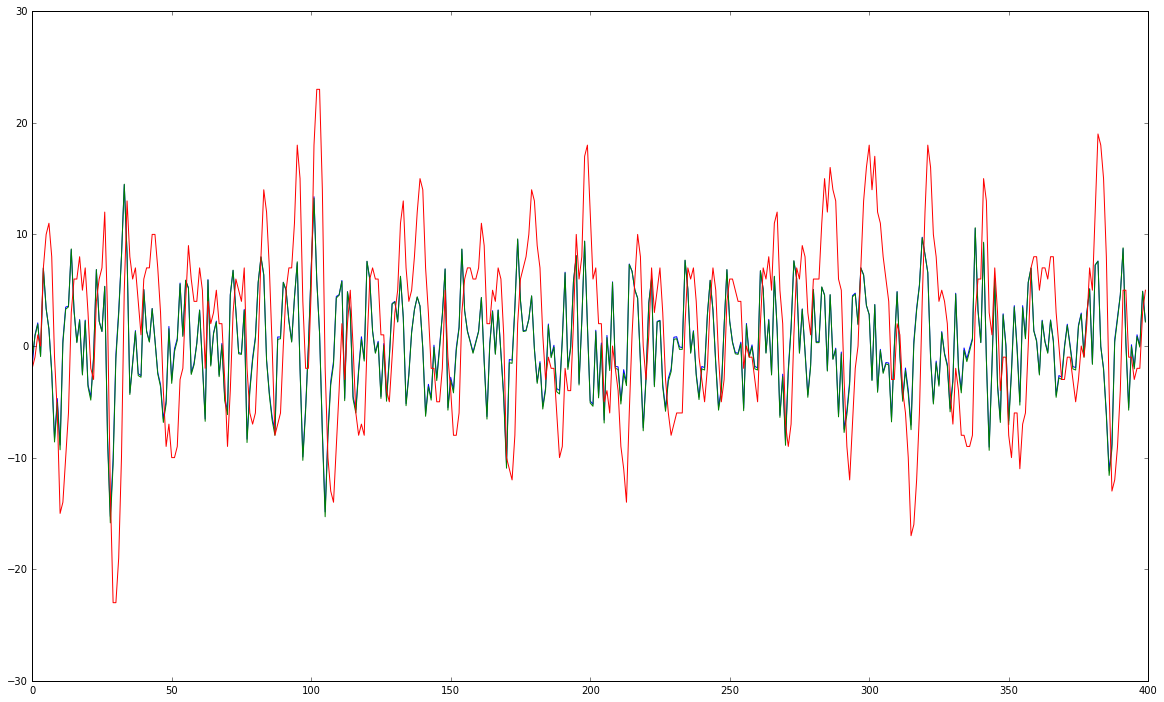

In [77]:
plt.figure(figsize=(20,12))

plt.plot(np.arange(400), y_pred[0].squeeze() * Y.std() + Y.mean())
plt.plot(np.arange(400), Y_norm[1000000].squeeze() * Y.std() + Y.mean())
plt.plot(np.arange(400), X_norm[1000000].squeeze() * X.std() + X.mean())
plt.show()

In [158]:
def fft_generator(frames, frames_normed):
    i = 0
    while True:
        if i >= len(frames):
            i = 0
        yield frames_normed[i], np.log(1 + powspec(np.expand_dims(frames[i].squeeze(), axis=0), 512))
        i += 1

In [124]:
def fft_generator_stop(frames):
    for frame in frames:
        yield powspec(np.expand_dims(frame.squeeze(), axis=0), 512)

In [128]:
X = None
X_norm = None

In [188]:
Y_fft_norm = np.expand_dims(np.log2(1+powspec(Y.squeeze(), 512)), axis=1)

In [317]:
Y_fft = powspec(Y.squeeze(), 512)

In [323]:
Y.squeeze().shape

(1128519, 400)

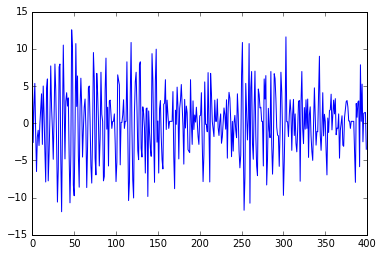

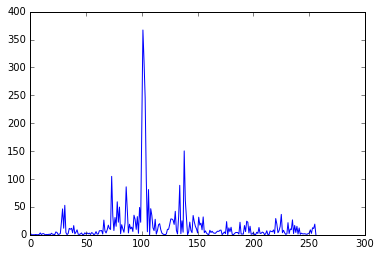

In [325]:
plt.plot(Y.squeeze()[0])
plt.show()
plt.plot(Y_fft[0])
plt.show()

In [321]:
np.savez('fft_matrices_small', fft_in=Y.squeeze()[:1000], fft_out=Y_fft[:1000])

In [166]:
Y_fft_norm.shape

(1128519, 1, 257)

In [135]:
fft_mean = np.mean(powspec(Y.squeeze(), 512))
fft_std = np.std(powspec(Y.squeeze(), 512))

In [138]:
fft_std

644141.98309723509

In [141]:
np.max((powspec(Y.squeeze(), 512))

KeyboardInterrupt: 

In [145]:
fft_mean

44796.92682141668

In [157]:
np.log(991764015 + 1)

20.714995748844444

In [143]:
(991764015 - fft_mean) / fft_std

1539.5972380261319

In [ ]:
#def sine_activation()

In [196]:
def fft_model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', input_dim=400))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(257, activation='relu'))
    
    model.summary()
    sgd = SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=[metrics.mae, metrics.mse])
    return model

In [198]:
model_fft = fft_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              410624    
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_11 (Dense)             (None, 257)               263425    
Total params: 1,723,649
Trainable params: 1,723,649
Non-trainable params: 0
_________________________________________________________________


In [120]:
powspec(Y[60:62].squeeze(), 512)

array([[  2.56730908e+01,   1.84854965e+01,   1.52346542e+01,
          8.02490382e+00,   4.57931809e+01,   3.60681202e+02,
          2.36554615e+03,   1.18650247e+04,   1.33142501e+02,
          7.53516403e+02,   7.52031754e+02,   5.97327301e+02,
          1.61403097e+02,   1.37681423e+04,   1.41242499e+04,
          1.46581313e+02,   8.62782334e+02,   1.76570521e+03,
          4.83945736e+03,   2.37429742e+03,   7.29416688e+04,
          2.61980702e+04,   5.54488102e+03,   9.31183234e+00,
          6.81285938e+02,   9.44737040e+03,   2.07102715e+04,
          2.18173198e+05,   1.69185682e+04,   2.33677704e+04,
          2.73732547e+03,   1.67145123e+02,   1.04523480e+04,
          3.00969278e+04,   6.05645078e+04,   3.05731657e+03,
          5.97717802e+03,   3.12838943e+02,   2.59719694e+02,
          1.85523057e+03,   8.56513013e+03,   4.69651431e+03,
          4.00666737e+02,   9.02505478e+01,   7.40565957e+00,
          4.78343530e+01,   1.95908920e+02,   2.75786846e+03,
        

In [153]:
np.sqrt(0)

0.0

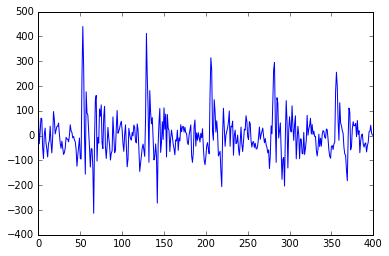

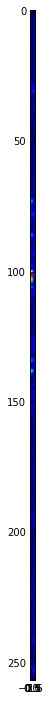

In [121]:
plt.plot(Y[60].squeeze())
plt.show()
plt.figure(figsize=(20,12))
plt.imshow(powspec(Y[0:100].squeeze(), 512).transpose())
plt.show()

In [199]:
model_fft.fit(Y_norm.squeeze(), Y_fft_norm.squeeze())

Epoch 1/10
1128519/1128519 [==============================] - 1182s - loss: 9.5148 - mean_absolute_error: 2.2229 - mean_squared_error: 9.5148  
Epoch 2/10
 296928/1128519 [======>.......................] - ETA: 854s - loss: 6.9566 - mean_absolute_error: 1.8738 - mean_squared_error: 6.9566

KeyboardInterrupt: 

In [201]:
y_fft_pred = model_fft.predict(Y_norm[0:100].squeeze())

In [214]:
y_fft_pred.shape

(100, 257)

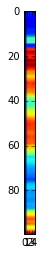

In [211]:
plt.imshow(y_fft_pred[:, 105:110])
plt.show()

In [212]:
y_fft_pred[:, 105]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

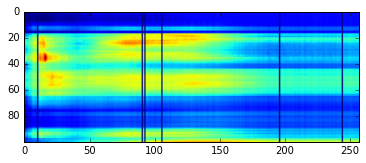

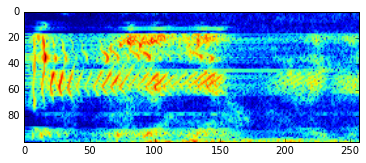

In [203]:
plt.imshow(y_fft_pred)
plt.show()
plt.imshow(Y_fft_norm[0:100].squeeze())
plt.show()

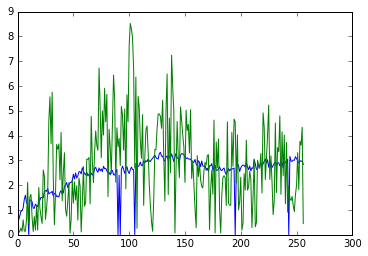

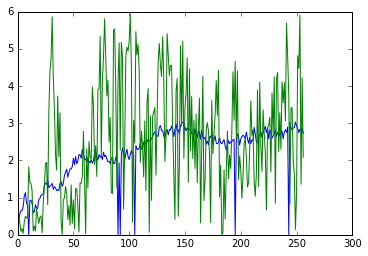

In [216]:
plt.plot(y_fft_pred[0])
plt.plot(Y_fft_norm[0,0])
plt.show()
plt.plot(y_fft_pred[1])
plt.plot(Y_fft_norm[1,0])
plt.show()

In [219]:
fft_input = Y[0, :, 0]

In [237]:
fft_input.shape

(400,)

In [235]:
fft_output = powspec(Y[:2].squeeze(), 512)[0]

In [236]:
fft_output.shape

(257,)

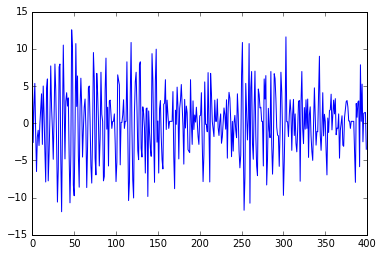

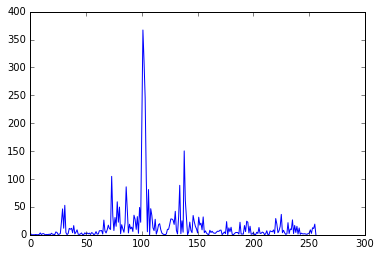

In [238]:
plt.plot(fft_input)
plt.show()
plt.plot(fft_output)
plt.show()

In [263]:
a = np.array([1+2j, 3+4j, 5+6j])

In [268]:
(1-1j)**2

-2j

In [270]:
np.pi

3.141592653589793

In [326]:
N = 512
K = 512

out = []
for k in range(0,K+1):
    x_out = 0
    for n in range(0, N):
        w = float(np.exp(-1j*k*n*((2*np.pi)/N)))
        if n < len(fft_input):
            x_n = fft_input[n] * w
        else:
            x_n = 0 * w
        x_out += x_n
    out.append(x_out)

/home/tvniedek/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [329]:
out

[45.10000000000003,
 -5.7394765966755834,
 -5.4620619849611778,
 5.7820183613426108,
 1.2553673021739349,
 7.7195293783000434,
 -7.0880030959156883,
 -1.3037402771023299,
 -16.018286168802476,
 23.264377304907104,
 5.5831665865620925,
 2.4170934902747629,
 15.186932401251607,
 14.700276372463684,
 4.0054790061049683,
 -17.347167942946264,
 -5.3992463808735458,
 23.538395915131655,
 -4.1779201304510032,
 8.907100027475428,
 23.135257351685084,
 14.28276382643593,
 0.97383773998581225,
 -8.7366171845417888,
 45.671506090382806,
 -7.0099170554634824,
 11.175227525942931,
 22.926544857014427,
 44.977300928581656,
 3.5673546832950733,
 1.189240432631899,
 -45.073533003029674,
 -14.732721878863101,
 -1.0386075023005497,
 11.413427323827108,
 41.247156363398275,
 -63.029288957930859,
 37.803315534378768,
 25.581082658873335,
 85.82007173614636,
 28.439713973598614,
 48.745213841277192,
 38.576017878286429,
 21.885966004184034,
 18.623468389999491,
 17.990678369845405,
 23.175860109585926,
 2.

In [290]:
complex_spec = np.fft.rfft(fft_input,512)

In [300]:
complex_spec

array([  4.51000000e+01 +0.00000000e+00j,
        -5.73947660e+00 -1.19572616e-01j,
        -5.46206198e+00 -4.80106414e+00j,
         5.78201836e+00 -8.58577622e+00j,
         1.25536730e+00 -7.08025405e+00j,
         7.71952938e+00 +1.43297281e+01j,
        -7.08800310e+00 -2.26348798e+00j,
        -1.30374028e+00 -7.24616615e+00j,
        -1.60182862e+01 +4.16322380e+00j,
         2.32643773e+01 +3.41744904e+01j,
         5.58316659e+00 -1.22417741e+01j,
         2.41709349e+00 +3.09408330e+01j,
         1.51869324e+01 -2.90002356e+01j,
         1.47002764e+01 +1.03553135e+01j,
         4.00547901e+00 -5.80205758e+00j,
        -1.73471679e+01 +6.38565443e+00j,
        -5.39924638e+00 +6.66660431e+00j,
         2.35383959e+01 +8.32460299e+00j,
        -4.17792013e+00 +7.29413423e+00j,
         8.90710003e+00 +3.64602729e+01j,
         2.31352574e+01 -5.36842151e+00j,
         1.42827638e+01 -1.15459296e+01j,
         9.73837740e-01 -1.37726765e+01j,
        -8.73661718e+00 +5.0421467

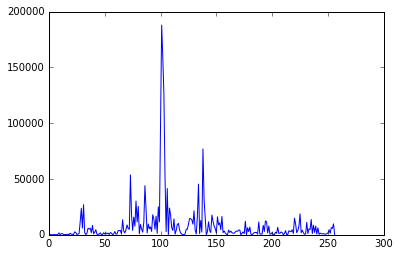

In [294]:
plt.plot(np.square(np.abs(complex_spec)))
plt.show()

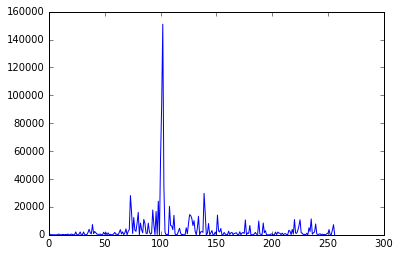

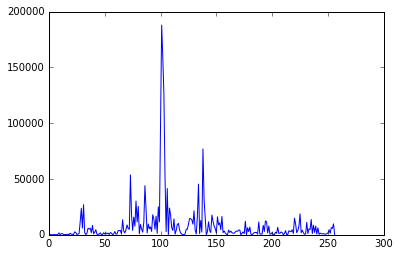

In [315]:
plt.plot(np.square(np.abs(out))[:257])
plt.show()
plt.plot(fft_output * 512)
plt.show()

# From power spectrum to 